# CSE527 Homework 5
**Due date: 23:59 on May 8, 2021 (Saturday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.







In [1]:
pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6MB 163kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/My Drive/JAIN_MAYANK_113263864_hw5'


/content/gdrive/My Drive/JAIN_MAYANK_113263864_hw5


## Problem 1: Ray casting using Blinn-Phong model


## Description
----
In this problem, you will be estimating the camera captured image given the camera parameters, scene geometry, lighting and materials using 
[Blinn-Phong illumination model](https://dl.acm.org/doi/abs/10.1145/563858.563893), an improved version of [Phong illumination model](https://dl.acm.org/doi/abs/10.1145/360825.360839).

The six parts below will guide you to render an image using ray casting and Phong model step by step.

In [4]:
# import packages here
import numpy as np
import cv2 as cv
from math import sqrt, fmod, pi
import matplotlib.pyplot as plt

print(cv.__version__) # verify OpenCV version

# figure and show
def imshow(im, title=None):
    im = im.squeeze()

    # remove white paddings
    fig = plt.figure()
    # fig.canvas.window().statusBar().setVisible(False)

    # display image
    ax = plt.imshow(im, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if title is not None:
        plt.title(title)
        plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0, hspace=0, wspace=0)
    plt.show()
    return fig

# A 3x1 vector class extended from np.ndarray
class Vec3(np.ndarray):
    def __new__(cls, x, y=None, z=None):
        if y is None and z is None:
            data = np.array([x, x, x])
        else:
            data = np.array([x, y, z])
        return data.view(cls)

    # vector normal
    def norm(self):
        return np.linalg.norm(self)

    # normalized vector
    def normalize(self):
        return self / self.norm()

    # vector cross product
    def cross(self, b):
        return np.cross(self, b)

3.4.2


### Part 1: Compute camera intrinsic matrix and camera ray
(15 points) Compute the 3x3 camera intrinsic matrix from the given camera image size, sensor size and focal length. Then, for each camera image pixel, we shoot a camera ray from the camera optical center (ray origin) and pass it through the pixel. Implement your alogrithm in `cam_ray_dir`. 

**Hint**: refer to slides, you will compute each camera ray direction using inverse of camera matrix.


In [5]:
# create a perspective camera model. DO NOT MODIFY them
cam_pos = Vec3(0, 0, 0)
cam_h, cam_w = (500, 500)  # camera image size (pixel)
sensor_h, sensor_w = (36, 36)  # camera sensor size (mm)
focal_length = 50  # camera lens focal length (mm)

fx, fy = (focal_length / sensor_w * cam_w, focal_length / sensor_h * cam_h)
cx, cy = (cam_w / 2, cam_h / 2)
cam_k = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])  # camera intrinsics

inv_cam_k = np.linalg.inv(cam_k)  # precompute inverse of camera intrinsics

# compute the direction of the camera ray that passes through camera optical center (ray origin) and pixel (x, y)
def cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y):
  ray_dir = None

  ##########--WRITE YOUR CODE HERE--##########
  ray_dir = Vec3(0, 0, 0)
  dot_product = np.dot(inv_cam_k,Vec3(x, y, 1))
  prod_of_focal_length_andDotProduct = focal_length * dot_product
  ray_dir = prod_of_focal_length_andDotProduct - cam_pos
  ray_dir = ray_dir.normalize()
  ##########-------END OF CODE-------##########
  return ray_dir

print('camera intrinsics = \n', cam_k)

camera intrinsics = 
 [[694.44444444   0.         250.        ]
 [  0.         694.44444444 250.        ]
 [  0.           0.           1.        ]]


### Part 2: Compute ray-object intersection
(15 points) For each camera ray, you will compute the intersection point of the camera ray with each object in the scene and store the intersection information in an `Intersection` object. Implement sphere-ray intersections, plane-ray intersections and ray-scene intersections below.

In [7]:
# A class used to store ray-object intersection information
class Intersection(object):
    def __init__(self, point, distance, normal, obj):
        self.p = point  # intersection point/position
        self.d = distance  # distance between this intersection and ray origin
        self.n = normal  # surface normal at this intersection
        self.obj = obj  # which object this intersection belongs to

# Light ray class
class Ray(object):
    def __init__(self, origin, direction):
        self.o = origin
        self.d = direction

    # ray-object intersection
    def intersect(self, obj):
        return obj.intersect(self)

    # ray intersect scene i.e., check intersections with all objects.
    # return the closest if at lease one intersection, otherwise return none
    def intersect_scene(self, scene, ignored_obj=None):
        inter = None # returned inter is an instance of Intersection
        
        ##########--WRITE YOUR CODE HERE--##########
        object_intersections = []
        
        for s in scene:
          object_intersections.append(s.intersect(self))
        
        minimum_direction_value = np.inf

        for intersect in object_intersections:
          if intersect is not None:
            if minimum_direction_value > intersect.d :
              minimum_direction_value = intersect.d
              inter = intersect

        ##########-------END OF CODE-------##########
       
        return inter

# Sphere class
class Sphere(object):
    def __init__(self, center, radius, material=None):
        self.c = center
        self.r = radius
        self.rr = radius ** 2  # precompute r^2 for faster ray casting
        self.mat = material  # Phong material

    def intersect(self, l):  # intersect with ray l
        inter = None # returned inter is an instance of Intersection
        # solve quadratic equation of ray-sphere intersection

        ##########--WRITE YOUR CODE HERE--##########
        quad_coeff = np.dot(l.d, l.d)
        linear_coeff = np.dot((l.o - self.c), l.d) * 2
        constant = np.dot((l.o - self.c), (l.o - self.c)) - self.rr
        discriminant = pow(linear_coeff,2) - 4 * quad_coeff * constant
        
        if discriminant < 0:
          return None
    
        root1 = (-1 * linear_coeff + pow(discriminant,0.5)) / (2 * quad_coeff)
        root2 = (-1 * linear_coeff - pow(discriminant,0.5)) / (2 * quad_coeff)
        
        if root1 < 0 and root2 < 0:
          return None

        a_intersection = l.o + l.d * root1
        b_intersection = l.o + l.d * root2

        if np.linalg.norm(l.o - a_intersection) <= np.linalg.norm(l.o - b_intersection):
          intersection_origin_dist = np.linalg.norm(l.o - a_intersection)
          s_normal = (a_intersection - self.c).normalize()
          inter = Intersection(a_intersection, intersection_origin_dist, s_normal, self)
          
        else:
          intersection_origin_dist = np.linalg.norm(l.o - b_intersection)
          s_normal = (b_intersection - self.c).normalize()
          inter = Intersection(b_intersection, intersection_origin_dist, s_normal, self)

        ##########-------END OF CODE-------##########
        return inter


# Plane class
class Plane(object):
    def __init__(self, point, normal, material=None):
        self.p = point  # a point on the plane
        self.n = normal  # must be a normalized Vec3
        self.mat = material  # Phong material

    def intersect(self, l):  # intersect with ray l
        inter = None # returned inter is an instance of Intersection

        ##########--WRITE YOUR CODE HERE--##########
        numerator = np.dot((self.p - l.o), self.n)
        denominator = np.dot(l.d, self.n)
        res = numerator/denominator
        
        if res < 0:
          return None

        intersection = (l.d * res) + l.o
        dist = np.linalg.norm(l.o - intersection)
        inter = Intersection(intersection, dist, self.n, self)

        ##########-------END OF CODE-------##########

        return inter

### Part 3: Render a vanilla ray casting image
(15 points) This part aims to help you sanity check the ray-object intersection algorithms above by rendering an image with `vanilla_ray_cast `. You will set a camera image pixel to (0.5,0.5,0.5) if its corresponding camera ray hits an object in the scene, otherwise set it to (0,0,0). You will compute the ray direction using `cam_ray_dir` and create a variable `ray` using `Ray(origin, dir)`, then `vanilla_ray_cast` will compute the current pixel color.

Ray casting...
0.00%
10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%
80.00%
90.00%


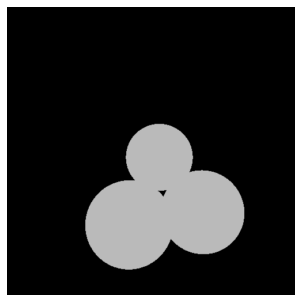

True

In [8]:
#  Only check if ray intersects the objects or not, does not computer color
def vanilla_ray_cast(ray, objects):
    inter = ray.intersect_scene(objects)
    if inter is None:
        color = Vec3(0, 0, 0)
    else:
        color = Vec3(1, 1, 1)*0.5
    return color
    
# initialize scene with three spheres
scene = []  # scene stores a list of objects
scene.append(Sphere(Vec3(12, 9, 600), 50))
scene.append(Sphere(Vec3(-30, 100, 550), 60))
scene.append(Sphere(Vec3(80, 95, 630), 65))

# camera captured image
img = np.zeros((cam_h, cam_w, 3))

# render using ray casting
print('Ray casting...')
for x in range(cam_w):  # for each col
    if fmod(x, cam_w // 10) == 0:  # print ray casting progress
        print('{:.2f}%'.format(x / cam_w * 100))
    for y in range(cam_h):  # for each row

        ##########--WRITE YOUR CODE HERE--##########     
        cameraRayCast = cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y)
        ray = Ray(cam_pos, cameraRayCast)   

        ##########-------END OF CODE-------##########

        color = vanilla_ray_cast(ray, scene)
        img[y, x] = color

# apply gamma correction (1/2.2) for display
img = np.power(img, 1 / 2.2)
imshow(img)
cv.imwrite('vanilla_ray_cast.png', img[..., ::-1] * 255)



### Part 4: Render a Lambertian ray casting image
(15 points) If Part 3 is correctly implemented, you can estimate a simple lambertian shadings of the scene (add light, material but ignore shadow, ambient and specular). 
Implement your algorithm in `diffuseColor`. Since we are dealing with colors, Phong materials are created and each object is assigned with a material.

In [ ]:
# Light source (point light)
class Light(object):
    def __init__(self, position, power, ambient, diffuse, specular):
        self.p = position  # position, Vec3
        self.power = power  # light intensity/brightness
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular

# Phong diffuse (lambertian) color
def diffuseColor(inter, light):
    color = 0

    ##########--WRITE YOUR CODE HERE--##########
    normalized_diffOfPoints = (light.p - inter.p).normalize()
    prod_point_and_normal = np.dot(normalized_diffOfPoints, inter.n)
    color = inter.obj.mat['kd'] * prod_point_and_normal * light.power * light.diffuse

    ##########-------END OF CODE-------##########
    
    return color

#  Only compute lambertian (diffuse) color, no ambient or shadow
def lambertian_ray_cast(ray, objects, light):
    inter = ray.intersect_scene(objects)
    if inter is None:
        color = Vec3(0, 0, 0)
    else:
        d = (light.p - inter.p).norm()
        color = np.clip(diffuseColor(inter, light) / (4 * pi * d * d), 0, 1)
    return color

# Render
# Phong illumination materials
plaster_white = {'ka': Vec3(0.03), 'kd': Vec3(0.5), 'ks': Vec3(0.1), 'shine': 5}
plaster_red = {'ka': Vec3(0.9, 0.1, 0.1) * 0.01, 'kd': Vec3(0.9, 0.1, 0.1), 'ks': Vec3(0.1), 'shine': 5}
plaster_green = {'ka': Vec3(0.1, 0.9, 0.1) * 0.01, 'kd': Vec3(0.1, 0.9, 0.1), 'ks': Vec3(0.1), 'shine': 5}
marble_white = {'ka': Vec3(0.01), 'kd': Vec3(0.8), 'ks': Vec3(1.0), 'shine': 200.0}
marble_yellow = {'ka': Vec3(0.8, 0.8, 0.1) * 0.1, 'kd': Vec3(0.8, 0.8, 0.1), 'ks': Vec3(1.0), 'shine': 200.0}
plastic_red = {'ka': Vec3(0.7, 0.1, 0.2) * 0.01, 'kd': Vec3(0.7, 0.1, 0.2), 'ks': Vec3(0.2), 'shine': 20}

# initialize scene with spheres and a box
scene = []  # scene stores a list of objects
# a box
scene.append(Plane(Vec3(0, -160, 0), Vec3(0, 1, 0), plaster_white))  # ceiling
scene.append(Plane(Vec3(0, 160, 0), Vec3(0, -1, 0), plaster_white))  # floor
scene.append(Plane(Vec3(-160, 0, 0), Vec3(1, 0, 0), plaster_red))  # left
scene.append(Plane(Vec3(160, 0, 0), Vec3(-1, 0, 0), plaster_green))  # right
scene.append(Plane(Vec3(0, 0, 780), Vec3(0, 0, -1), plaster_white))  # back
# spheres
scene.append(Sphere(Vec3(12, 9, 600), 50, marble_white))
scene.append(Sphere(Vec3(-30, 100, 550), 60, marble_yellow))
scene.append(Sphere(Vec3(80, 95, 630), 65, plastic_red))

# initialize a point light
light = Light(Vec3(-68, -68, 400), 300000, Vec3(1.0), Vec3(1.0), Vec3(1.0))

# camera captured image
img = np.zeros((cam_h, cam_w, 3))

# render using ray casting
print('Ray casting...')
for x in range(cam_w):  # for each col
    if fmod(x, cam_w // 10) == 0:  # print ray casting progress
        print('{:.2f}%'.format(x / cam_w * 100))
    for y in range(cam_h):  # for each row

        ##########--WRITE YOUR CODE HERE--##########     
        
        cameraRayCast = cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y)
        ray = Ray(cam_pos, cameraRayCast)

        ##########-------END OF CODE-------##########

        color = lambertian_ray_cast(ray, scene, light)
        img[y, x] = color

# apply gamma correction (1/2.2) for display
img = np.power(img, 1 / 2.2)
imshow(img)
cv.imwrite('lambertian_ray_cast.png', img[..., ::-1] * 255)



Ray casting...
0.00%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide


10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%


## What's more?
(0 points) For curious students

1.   Is the above image photorealistic enough? How can we improve it?
  *  Add more lights, materials and objects.
  *  Add textures.
  *  Render triangle mesh.
  *  Acceleration techniques, e.g., depth clipping, bounding box, BVH, k-d tree, multithreading, GPU.
  *  Antialiasing.
  *  Depth of field.
  *  Add transparency, inter-reflection, volume scattering, caustics, etc.


2.   How do human visual systems tell whether an image is real or fake? Apparently shadow is an important cue.
3.   Inverse problem: can we estimate lighting (direction and color), object surface normal, material and camera parameters from the image above?







## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw5' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
```

For instance, student Michael Jordan should submit a zip file named "Lecun_Yann_111134567_hw5.zip" for homework5 in this structure:
```
Lecun_Yann_111134567_hw5
        |---Lecun_Yann_111134567_hw5.ipynb
        |---Lecun_Yann_111134567_hw5.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

